In this notebook we analyze and plot the results from predicting affect changes

In [45]:
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import matplotlib.pylab as plt
import seaborn as sns

from scipy.stats import norm
from time import time
from joblib import Parallel, delayed

from nilearn.masking import unmask, apply_mask
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from joblib import Memory, dump
from tempfile import mkdtemp
from my_sklearn_tools.model_selection import StratifiedKFoldReg
from sklearn.linear_model._coordinate_descent import _alpha_grid

from nilearn.image import load_img,resample_img

In [12]:
Y_df = pd.read_csv("../data/target_data.csv")
print(Y_df.shape)
X = np.load("../data/input_data.npz")

cv = StratifiedKFoldReg(n_splits=5, random_state=0, shuffle=True)
n_alphas=1000

mask_img = load_img("../data/reslicedER_grey25grey25.nii")

amygdala_mask_img = resample_img("../data/amygdala_mask.nii", 
                                 mask_img.affine,
                                 mask_img.shape,
                                 interpolation='nearest')
n_boots = 1000

(145, 21)


In [7]:
def compute_ci(y_pred, y_true, n_boots=1000, alpha=0.05, random_state=None):
    n_obs = len(y_pred)
    idxs = np.arange(n_obs)
    
    np.random.seed(random_state)
    r_boots, r2_boots, mae_boots = [], [], []
    for ii in range(n_boots):
        idxs_boot = np.random.choice(idxs, n_obs)
        y_pred_boot = y_pred[idxs_boot]
        y_true_boot = y_true[idxs_boot]
        
        r = np.corrcoef(y_true_boot, y_pred_boot)[0,1]
        r2 = r2_score(y_true_boot, y_pred_boot)
        mae = mean_absolute_error(y_true_boot, y_pred_boot)
        
        r_boots.append(r)
        r2_boots.append(r2)
        mae_boots.append(mae)
    
    res_dict = dict()
    
    res_dict['r'] = np.quantile(r_boots, q=[alpha/2, 1-alpha/2])
    res_dict['r2'] = np.quantile(r2_boots, q=[alpha/2, 1-alpha/2])
    res_dict['mae'] = np.quantile(mae_boots, q=[alpha/2, 1-alpha/2])
    
    return res_dict

In [37]:
def extract_map(pip, X, mask_img):
    """
    Function to extract the phenotype maps
    
    """
    from sklearn.preprocessing import StandardScaler
    
    ss = StandardScaler(with_std=False) # We need this because we are using the mean substracted features
                                        # This is important for computing the encoding maps
        
    V = pip.named_steps['pca'].components_ # PCA transformation
    beta =  pip.named_steps['lasso'].coef_ # Coefficients in the PC space
    insert_voxels = pip.named_steps['variancethreshold'].inverse_transform
    filter_voxels = pip.named_steps['variancethreshold'].transform
    
    phenotypes_dict = dict()
    
    w = V.T @ beta    
    w_dec = np.squeeze(insert_voxels(w[None, :]))
    phenotypes_dict['w_dec'] = w_dec
    
    X_mean = ss.fit_transform(X)
    X_vt = filter_voxels(X_mean) # Concentrate on the voxels used
    w_enc = X_vt.T @ (X_vt @ w)
    w_enc = np.squeeze(insert_voxels(w_enc[None,:]))
    phenotypes_dict['w_enc'] = w_enc
    
    return phenotypes_dict


def run_lassocv(X, y, n_splits, n_alphas, random_state):
    cv = StratifiedKFoldReg(n_splits=n_splits, random_state=random_state, shuffle=True)
    
    pip_transf = make_pipeline(VarianceThreshold(), PCA())
    alphas = _alpha_grid(pip_transf.fit_transform(X), y, n_alphas=n_alphas)
    
    # Generate list of estimators to fit
    estimators = [Lasso(alpha=alpha) for alpha in alphas]

    scores_cv = np.zeros((n_alphas, n_splits))
    for i_fold, (train_index, test_index) in enumerate(cv.split(X, y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        pip_transf = make_pipeline(VarianceThreshold(), PCA())        
        X_train_trans = pip_transf.fit_transform(X_train)
        X_test_trans = pip_transf.transform(X_test)
        
        estimators_fit = [estim.fit(X_train_trans, y_train) for estim in estimators]
        scores = [mean_squared_error(y_test, estim.predict(X_test_trans)) for estim in estimators_fit]
        scores_cv[:, i_fold] = scores
        
    scores_cv_mean = np.mean(scores_cv, axis=1)
    alpha_opt = alphas[np.argmin(scores_cv_mean)]
    
    pip_opt =  make_pipeline(VarianceThreshold(), PCA(), Lasso(alpha=alpha_opt))
    pip_opt.fit(X, y)
    
    return {'estimator':pip_opt, 'scores_cv_mean': scores_cv_mean, 'alphas': alphas}
    

def compute_phenotypes(X, y, random_state, n_alphas=1000, n_splits=5):
#     cv = StratifiedKFoldReg(n_splits=n_splits, random_state=random_state, shuffle=True)
    
#     pip_transf = make_pipeline(VarianceThreshold(), PCA())
#     alphas = _alpha_grid(pip_transf.fit_transform(X), y, n_alphas=n_alphas)
    
#     # Generate list of estimators to fit
#     estimators = [Lasso(alpha=alpha) for alpha in alphas]

#     scores_cv = np.zeros((n_alphas, n_splits))
#     for i_fold, (train_index, test_index) in enumerate(cv.split(X, y)):
#         X_train, X_test = X[train_index], X[test_index]
#         y_train, y_test = y[train_index], y[test_index]
        
#         pip_transf = make_pipeline(VarianceThreshold(), PCA())        
#         X_train_trans = pip_transf.fit_transform(X_train)
#         X_test_trans = pip_transf.transform(X_test)
        
#         estimators_fit = [estim.fit(X_train_trans, y_train) for estim in estimators]
#         scores = [mean_squared_error(y_test, estim.predict(X_test_trans)) for estim in estimators_fit]
#         scores_cv[:, i_fold] = scores
        
#     scores_cv_mean = np.mean(scores_cv, axis=1)
#     alpha_opt = alphas[np.argmin(scores_cv_mean)]
    
#     pip_opt =  make_pipeline(VarianceThreshold(), PCA(), Lasso(alpha=alpha_opt))
#     pip_opt.fit(X, y)
    
    pip_opt, _,_ = run_lassocv(X, y, n_splits, n_alphas, random_state)
    phenotypes = extract_map(pip_opt, X, mask_img)
    return phenotypes


def run_bootstrap(X, y, boot_id):
    from sklearn.utils import resample

    X_boot, y_boot = resample(X, y, random_state=boot_id) # set to boot_id for reproducbility
    
    phenotypes = compute_phenotypes(X_boot, y_boot, random_state=boot_id) # set to boot_id for reproducbility
    return phenotypes

In [9]:
def _compute_pval(s, sboot):
    n_boots = len(sboot)
    if np.sign(s) == 1:
        pv = 2*(1-sum(sboot>0)/n_boots)
    elif np.sign(s) == -1:
        pv = 2*(1-sum(sboot<0)/n_boots)
    else:
        pv = 1
    return pv

def compute_pvals(w, w_boot, n_jobs=1):
    from joblib import Parallel, delayed
    n_features = len(w)
    pvals = Parallel(n_jobs=n_jobs)(delayed(_compute_pval)(w[ii], w_boot[:,ii]) for ii in range(n_features))
    pvals = np.array(pvals)
    pvals[pvals>1]=1
    return pvals

def threshold_weights(w, pvals, mask_img, alpha=0.05, k=50):
    from nilearn.glm import threshold_stats_img
    from nilearn.masking import unmask
    
    mask = pvals < alpha
    
    w_masked = (w*mask)
    weight_img = unmask(w_masked, mask_img=mask_img)
    
    weight_img_thr = threshold_stats_img(weight_img, 
                                         height_control=None, 
                                         threshold=0.0, 
                                         cluster_threshold=k)[0]
    
    return weight_img_thr

# CASE 1: Look Negative vs Look Neutral -> chg_LNeg_LNur 

In [10]:
# Load data
X_1 = X['look_neg_look_neut']
y_1 = Y_df.loc[:, "chg_LNeg_LNur"].to_numpy()

# y_preds_1_df = pd.read_csv("../results/prediction/chg_LNeg_LNur/look_neg_look_neut/y_preds.csv")

In [11]:
res_1 = compute_phenotypes(X_1, y_1, random_state=0)
w_dec_1 = res_1['w_dec']
w_enc_1 = res_1['w_enc']

In [13]:
# t_0 = time()
# res_boots_1 = Parallel(n_jobs=10)(delayed(run_bootstrap)(X_1, y_1, boot_id) \
#                                   for boot_id in tqdm(np.arange(n_boots)))
# t_f = time()

# w_dec_boot_1 = np.array([res['w_dec'] for res in res_boots_1])

# np.save("../results/prediction/chg_LNeg_LNur/look_neg_look_neut/decoding_weights_boots.npy", 
#         w_dec_boot_1)

# w_enc_boot_1 = np.array([res['w_enc'] for res in res_boots_1])

# np.save("../results/prediction/chg_LNeg_LNur/look_neg_look_neut/encoding_weights_boots.npy", 
#         w_enc_boot_1)

In [14]:
w_dec_boot_1 = np.load("../results/prediction/chg_LNeg_LNur/look_neg_look_neut/decoding_weights_boots.npy")
w_enc_boot_1 = np.load("../results/prediction/chg_LNeg_LNur/look_neg_look_neut/encoding_weights_boots.npy")

In [15]:
# Compute p-values
pvals_dec_1 = compute_pvals(w_dec_1, w_dec_boot_1, n_jobs=10)
pvals_enc_1 = compute_pvals(w_enc_1, w_enc_boot_1, n_jobs=10)

In [16]:
w_dec_1_img = unmask(w_dec_1, mask_img)
w_dec_1_img_thr = threshold_weights(w_dec_1, pvals_dec_1, mask_img=mask_img, alpha=0.05, k=50)

w_enc_1_img = unmask(w_enc_1, mask_img)
w_enc_1_img_thr = threshold_weights(w_enc_1, pvals_enc_1, mask_img=mask_img, alpha=0.05, k=50)

/home/javi/Documentos/software/nilearn/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [87]:
# Save images
w_dec_1_img.to_filename("../images/LookNeg_LookNeut_diff_ratings_weights_decoding.nii.gz")
w_dec_1_img_thr.to_filename("../images/LookNeg_LookNeut_diff_ratings_weights_thr_k50_decoding.nii.gz")

w_enc_1_img.to_filename("../images/LookNeg_LookNeut_diff_ratings_weights_encoding.nii.gz")
w_enc_1_img_thr.to_filename("../images/LookNeg_LookNeut_diff_ratings_weights_thr_k50_encoding.nii.gz")

In [94]:
foo = apply_mask(w_enc_1_img_thr, mask_img)

In [88]:
print("DECODING: number of predictive voxels = %d" % np.sum(abs(w_dec_1_img_thr.get_fdata())>0))
print("ENCODING: number of predictive voxels = %d" % np.sum(abs(w_enc_1_img_thr.get_fdata())>0))

DECODING: number of predictive voxels = 12980
ENCODING: number of predictive voxels = 10244


/home/javi/Documentos/software/nilearn/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


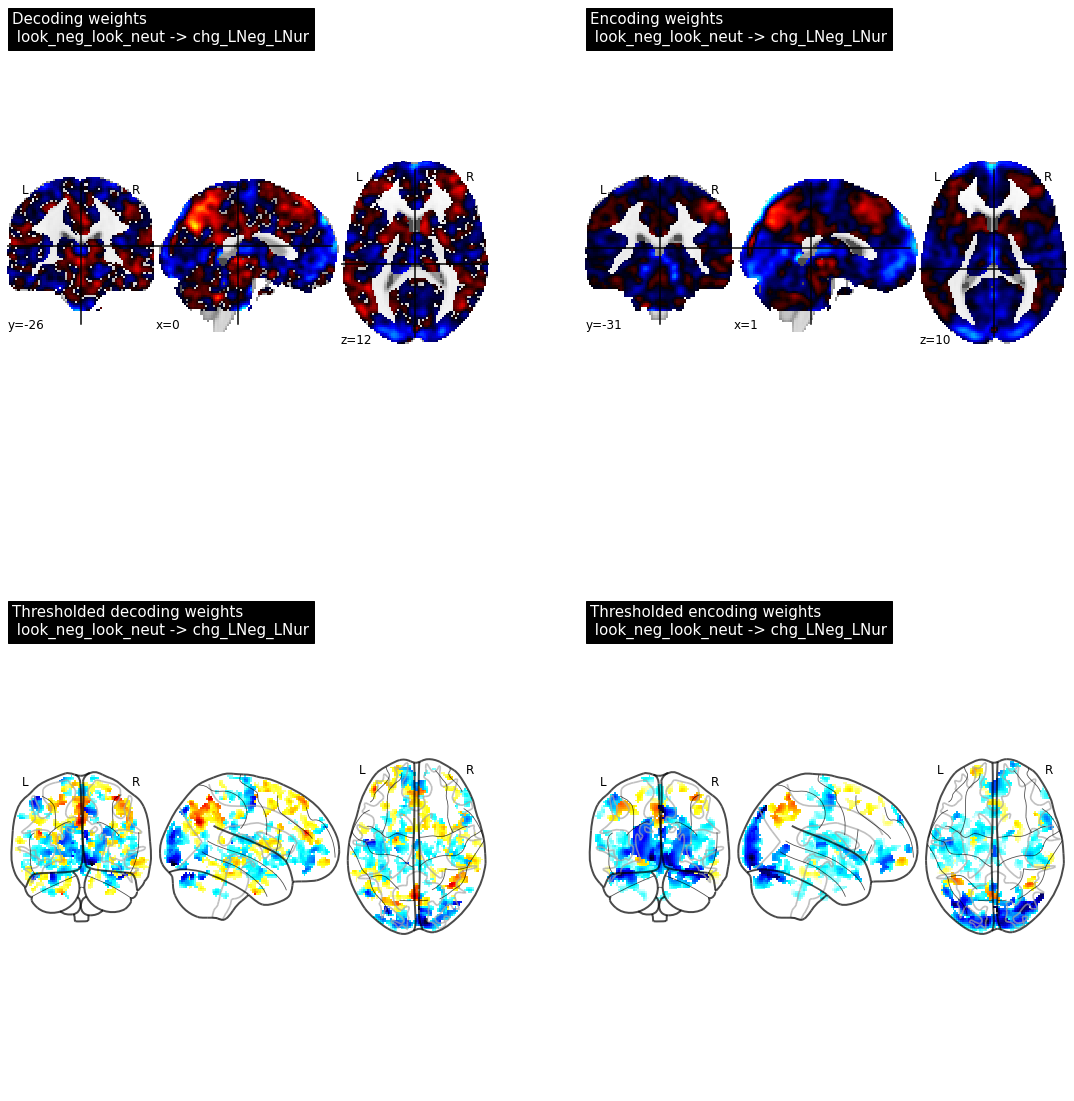

In [19]:
from nilearn import plotting
fig, axs = plt.subplots(ncols = 2, nrows=2, figsize=(19, 20))
plotting.plot_stat_map(w_dec_1_img, 
                       title = "Decoding weights \n look_neg_look_neut -> chg_LNeg_LNur", 
                       axes = axs[0,0],
                      colorbar=False)
plotting.plot_stat_map(w_enc_1_img, 
                       title = "Encoding weights \n look_neg_look_neut -> chg_LNeg_LNur", 
                       axes = axs[0,1],
                      colorbar=False)
plotting.plot_glass_brain(w_dec_1_img_thr, 
                          title = "Thresholded decoding weights \n look_neg_look_neut -> chg_LNeg_LNur", 
                          axes = axs[1,0],
                          plot_abs=False)
plotting.plot_glass_brain(w_enc_1_img_thr, 
                          title = "Thresholded encoding weights \n look_neg_look_neut -> chg_LNeg_LNur", 
                          axes = axs[1,1],
                          plot_abs=False)

In [21]:
print("DECODING CASE")
print("number of amygdala voxels = %d " % amygdala_mask_img.get_fdata().sum())
print("number of predictive amygdala voxels = %d " % sum(abs(apply_mask(w_dec_1_img_thr, amygdala_mask_img))>0))
print("number of predictive positve amygdala voxels = %d " % sum(apply_mask(w_dec_1_img_thr, amygdala_mask_img)>0))
print("number of predictive negative amygdala voxels = %d " % sum(apply_mask(w_dec_1_img_thr, amygdala_mask_img)<0))
print(" ")
print("ENCODING CASE")
print("number of amygdala voxels = %d " % amygdala_mask_img.get_fdata().sum())
print("number of predictive amygdala voxels = %d " % sum(abs(apply_mask(w_enc_1_img_thr, amygdala_mask_img))>0))
print("number of predictive positve amygdala voxels = %d " % sum(apply_mask(w_enc_1_img_thr, amygdala_mask_img)>0))
print("number of predictive negative amygdala voxels = %d " % sum(apply_mask(w_enc_1_img_thr, amygdala_mask_img)<0))

DECODING CASE
number of amygdala voxels = 468 
number of predictive amygdala voxels = 53 
number of predictive positve amygdala voxels = 0 
number of predictive negative amygdala voxels = 53 
 
ENCODING CASE
number of amygdala voxels = 468 
number of predictive amygdala voxels = 85 
number of predictive positve amygdala voxels = 0 
number of predictive negative amygdala voxels = 85 


In [34]:
# Statistics
res_ci = compute_ci(y_pred=y_preds_1_df.y_pred, y_true=y_preds_1_df.y_true, n_boots=1000, random_state=0)

print("R2 = %.3f [%.3f, %.3f]" % (r2_score(y_preds_1_df.y_true, y_preds_1_df.y_pred), 
                                  res_ci['r2'][0],
                                  res_ci['r2'][1]))

print("r = %.3f [%.3f, %.3f]" % (np.corrcoef(y_preds_1_df.y_true, y_preds_1_df.y_pred)[0,1], 
                                  res_ci['r'][0],
                                  res_ci['r'][1])
     )

print("MAE = %.3f [%.3f, %.3f]" % (mean_absolute_error(y_preds_1_df.y_true, y_preds_1_df.y_pred), 
                                  res_ci['mae'][0],
                                  res_ci['mae'][1]))

print("optimal lambda %f" % grid_1.best_params_['lasso__alpha'])
print("number of components selected = %d" % sum(grid_1.best_estimator_.named_steps['lasso'].coef_!=0))

R2 = 0.015 [-0.064, 0.075]
r = 0.143 [-0.015, 0.295]
MAE = 0.520 [0.454, 0.582]
optimal lambda 1.391426
number of components selected = 8


100%|██████████| 4/4 [00:03<00:00,  1.00it/s]


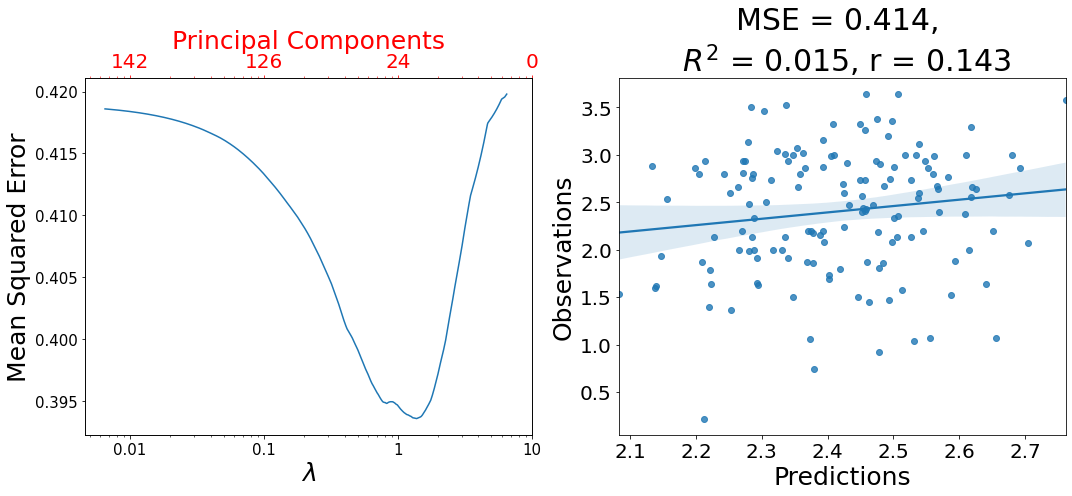

In [7]:
components_selected = []
for alpha in tqdm([0.01, 0.1, 1, 10]):
    pip.set_params(**{'lasso__alpha':alpha})
    pip.fit(X_1, y_1)
    components_selected.append(sum(pip.named_steps['lasso'].coef_!=0))

fig, ax = plt.subplots(ncols=2, figsize=(15,7))
ax[0].plot(alphas, -grid_1.cv_results_['mean_test_score'])
ax[0].set_xscale("log")
ax[0].set_xticks([0.01, 0.1, 1, 10])
ax[0].set_xticklabels(["0.01", "0.1", "1", "10"])
ax[0].set_xlabel(r'$\lambda$', size=25)
ax[0].set_ylabel("Mean Squared Error", size=25)
ax[0].tick_params(labelsize=15)
ax2 = ax[0].twiny()
ax2.plot(alphas, -grid_1.cv_results_['mean_test_score'], alpha=0)
ax2.set_xscale("log")
ax2.set_xticks([0.01, 0.1, 1, 10])
ax2.set_xticklabels(components_selected)
ax2.set_xlabel("Principal Components", size=25, color="red")
ax2.tick_params(axis='x', labelcolor="red", which="both", labelsize=20, color="red")

r = np.corrcoef(y_preds_1_df.loc[:,"y_true"],y_preds_1_df.loc[:,"y_pred"])[0,1]
r2 = r2_score(y_preds_1_df.loc[:,"y_true"],y_preds_1_df.loc[:,"y_pred"])
mse = mean_squared_error(y_preds_1_df.loc[:,"y_true"],y_preds_1_df.loc[:,"y_pred"])
sns.regplot(x="y_pred", y="y_true", data=y_preds_1_df, ax=ax[1], x_ci=None, n_boot=10000, seed=0)
ax[1].set_title("MAE = %.3f, \n $R^2$ = %.3f, r = %.3f"% (mse, r2, r), size=30)
ax[1].set_ylabel("Observations", size=25)
ax[1].set_xlabel("Predictions", size=25)
ax[1].tick_params(labelsize=20)
plt.tight_layout()
plt.savefig("../plots/Figure_chg_lneg_lneutr.png", dpi=300)
plt.savefig("../plots/Figure_chg_lneg_lneutr.svg", dpi=300)
plt.savefig("../plots/Figure_chg_lneg_lneutr.pdf", dpi=300)
pass

# CASE 2: Regulate Negative vs Look Negative -> chg_RNeg_LNeg 

In [22]:
# Load data
X_2 = X['reg_neg_look_neg']
y_2 = Y_df.loc[:, "chg_RNeg_LNeg"].to_numpy()

y_preds_2_df = pd.read_csv("../results/prediction/chg_RNeg_LNeg/reg_neg_look_neg/y_preds.csv")

In [23]:
res_2 = compute_phenotypes(X_2, y_2, random_state=0)
w_dec_2 = res_2['w_dec']
w_enc_2 = res_2['w_enc']

In [25]:
w_dec_boot_2 = np.load("../results/prediction/chg_RNeg_LNeg/reg_neg_look_neg/decoding_weights_boots.npy")
w_enc_boot_2 = np.load("../results/prediction/chg_RNeg_LNeg/reg_neg_look_neg/encoding_weights_boots.npy")

In [24]:
# t_0 = time()
# res_boots_2 = Parallel(n_jobs=10)(delayed(run_bootstrap)(X_2, y_2, boot_id) \
#                                   for boot_id in tqdm(np.arange(n_boots)))
# t_f = time()
# print("ellapsed time = ", t_f - t_0)

# w_dec_boot_2 = np.array([res['w_dec'] for res in res_boots_2])

# np.save("../results/prediction/chg_RNeg_LNeg/reg_neg_look_neg/decoding_weights_boots.npy", 
#         w_dec_boot_2)

# w_enc_boot_2 = np.array([res['w_enc'] for res in res_boots_2])

# np.save("../results/prediction/chg_RNeg_LNeg/reg_neg_look_neg/encoding_weights_boots.npy", 
#         w_enc_boot_2)

In [26]:
# Compute p-values
pvals_dec_2 = compute_pvals(w_dec_2, w_dec_boot_2, n_jobs=-1)
pvals_enc_2 = compute_pvals(w_enc_2, w_enc_boot_2, n_jobs=-1)

In [27]:
w_dec_2_img = unmask(w_dec_2, mask_img)
w_dec_2_img_thr = threshold_weights(w_dec_2, pvals_dec_2, mask_img=mask_img, alpha=0.05, k=50)

w_enc_2_img = unmask(w_enc_2, mask_img)
w_enc_2_img_thr = threshold_weights(w_enc_2, pvals_enc_2, mask_img=mask_img, alpha=0.05, k=50)

In [89]:
# Save images
w_dec_2_img.to_filename("../images/RegNeg_LookNeg_diff_ratings_weights_decoding.nii.gz")
w_dec_2_img_thr.to_filename("../images/RegNeg_LookNeg_diff_ratings_weights_thr_k50_decoding.nii.gz")

w_enc_2_img.to_filename("../images/RegNeg_LookNeg_diff_ratings_weights_encoding.nii.gz")
w_enc_2_img_thr.to_filename("../images/RegNeg_LookNeg_diff_ratings_weights_thr_k50_encoding.nii.gz")

In [90]:
print("DECODING: number of predictive voxels = %d" % np.sum(abs(w_dec_2_img_thr.get_fdata())>0))
print("ENCODING: number of predictive voxels = %d" % np.sum(abs(w_enc_2_img_thr.get_fdata())>0))

DECODING: number of predictive voxels = 24246
ENCODING: number of predictive voxels = 9865


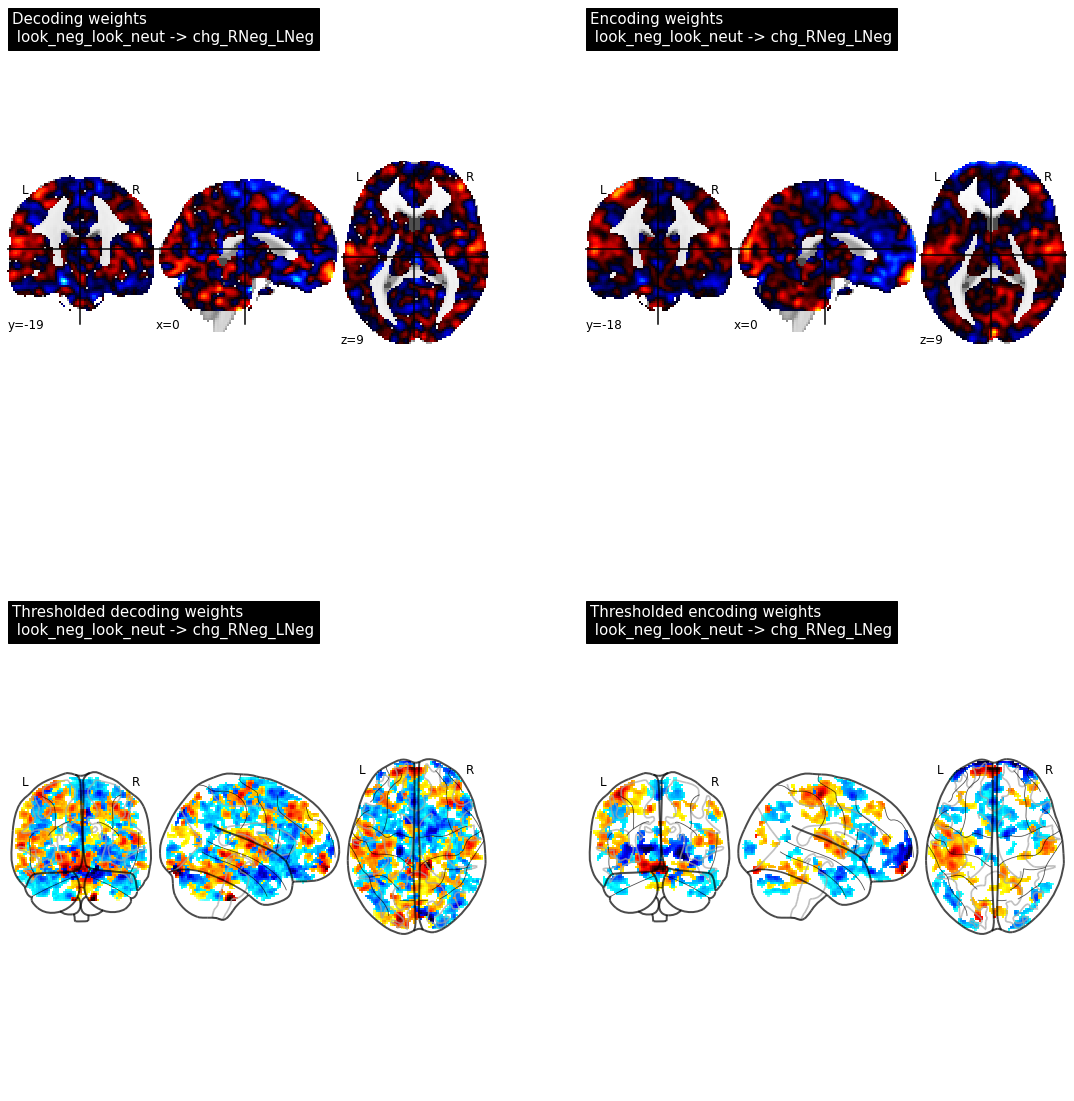

In [30]:
from nilearn import plotting
fig, axs = plt.subplots(ncols = 2, nrows=2, figsize=(19, 20))
plotting.plot_stat_map(w_dec_2_img, 
                       title = "Decoding weights \n look_neg_look_neut -> chg_RNeg_LNeg", 
                       axes = axs[0,0],
                      colorbar=False)
plotting.plot_stat_map(w_enc_2_img, 
                       title = "Encoding weights \n look_neg_look_neut -> chg_RNeg_LNeg", 
                       axes = axs[0,1],
                      colorbar=False)
plotting.plot_glass_brain(w_dec_2_img_thr, 
                          title = "Thresholded decoding weights \n look_neg_look_neut -> chg_RNeg_LNeg", 
                          axes = axs[1,0],
                          plot_abs=False)
plotting.plot_glass_brain(w_enc_2_img_thr, 
                          title = "Thresholded encoding weights \n look_neg_look_neut -> chg_RNeg_LNeg", 
                          axes = axs[1,1],
                          plot_abs=False)

In [31]:
print("DECODING CASE")
print("number of amygdala voxels = %d " % amygdala_mask_img.get_fdata().sum())
print("number of predictive amygdala voxels = %d " % sum(abs(apply_mask(w_dec_2_img_thr, amygdala_mask_img))>0))
print("number of predictive positve amygdala voxels = %d " % sum(apply_mask(w_dec_2_img_thr, amygdala_mask_img)>0))
print("number of predictive negative amygdala voxels = %d " % sum(apply_mask(w_dec_2_img_thr, amygdala_mask_img)<0))
print(" ")
print("ENCODING CASE")
print("number of amygdala voxels = %d " % amygdala_mask_img.get_fdata().sum())
print("number of predictive amygdala voxels = %d " % sum(abs(apply_mask(w_enc_2_img_thr, amygdala_mask_img))>0))
print("number of predictive positve amygdala voxels = %d " % sum(apply_mask(w_enc_2_img_thr, amygdala_mask_img)>0))
print("number of predictive negative amygdala voxels = %d " % sum(apply_mask(w_enc_2_img_thr, amygdala_mask_img)<0))

DECODING CASE
number of amygdala voxels = 468 
number of predictive amygdala voxels = 117 
number of predictive positve amygdala voxels = 13 
number of predictive negative amygdala voxels = 104 
 
ENCODING CASE
number of amygdala voxels = 468 
number of predictive amygdala voxels = 36 
number of predictive positve amygdala voxels = 0 
number of predictive negative amygdala voxels = 36 


In [31]:
# Statistics
res_ci = compute_ci(y_pred=y_preds_2_df.y_pred, y_true=y_preds_2_df.y_true, n_boots=1000, random_state=0)

print("R2 = %.3f [%.3f, %.3f]" % (r2_score(y_preds_2_df.y_true, y_preds_2_df.y_pred), 
                                  res_ci['r2'][0],
                                  res_ci['r2'][1]))

print("r = %.3f [%.3f, %.3f]" % (np.corrcoef(y_preds_2_df.y_true, y_preds_2_df.y_pred)[0,1], 
                                  res_ci['r'][0],
                                  res_ci['r'][1])
     )

print("MAE = %.3f [%.3f, %.3f]" % (mean_absolute_error(y_preds_2_df.y_true, y_preds_2_df.y_pred), 
                                  res_ci['mae'][0],
                                  res_ci['mae'][1]))

print("optimal lambda %f" % grid_2.best_params_['lasso__alpha'])
print("number of components selected = %d" % sum(grid_2.best_estimator_.named_steps['lasso'].coef_!=0))

R2 = 0.209 [0.073, 0.312]
r = 0.457 [0.307, 0.584]
MAE = 0.418 [0.367, 0.468]
optimal lambda 0.023291
number of components selected = 137


100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


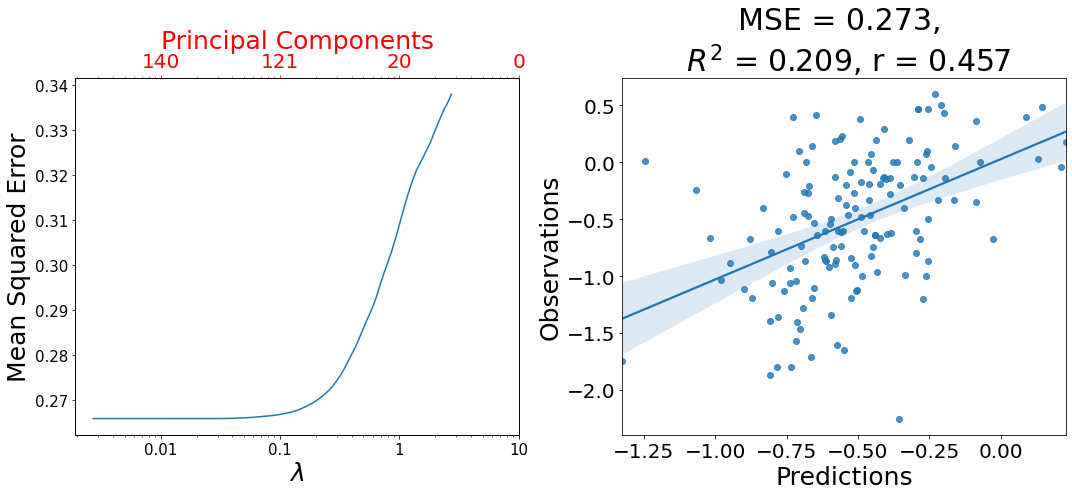

In [32]:
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mticker
components_selected = []
for alpha in tqdm([0.01, 0.1, 1, 10]):
    pip.set_params(**{'lasso__alpha':alpha})
    pip.fit(X_2, y_2)
    components_selected.append(sum(pip.named_steps['lasso'].coef_!=0))

fig, ax = plt.subplots(ncols=2, figsize=(15,7))
ax[0].plot(alphas, -grid_2.cv_results_['mean_test_score'])
ax[0].set_xscale("log")
ax[0].set_xticks([0.01, 0.1, 1, 10])
ax[0].set_xticklabels(["0.01", "0.1", "1", "10"])
ax[0].set_xlabel(r'$\lambda$', size=25)
ax[0].set_ylabel("Mean Squared Error", size=25)
ax[0].tick_params(labelsize=15)
ax2 = ax[0].twiny()
ax2.plot(alphas, -grid_2.cv_results_['mean_test_score'], alpha=0)
ax2.set_xscale("log")
ax2.set_xticks([0.01, 0.1, 1, 10])
ax2.set_xticklabels(components_selected)
ax2.set_xlabel("Principal Components", size=25, color="red")
ax2.tick_params(axis='x', labelcolor="red", which="both", labelsize=20, color="red")

r = np.corrcoef(y_preds_2_df.loc[:,"y_true"], y_preds_2_df.loc[:,"y_pred"])[0,1]
r2 = r2_score(y_preds_2_df.loc[:,"y_true"], y_preds_2_df.loc[:,"y_pred"])
mse = mean_squared_error(y_preds_2_df.loc[:,"y_true"],y_preds_2_df.loc[:,"y_pred"])
sns.regplot(x="y_pred", y="y_true", data=y_preds_2_df, ax=ax[1], x_ci=None, n_boot=10000, seed=0)
ax[1].set_title("MSE = %.3f, \n $R^2$ = %.3f, r = %.3f"% (mse, r2, r), size=30)
ax[1].set_ylabel("Observations", size=25)
ax[1].set_xlabel("Predictions", size=25)
ax[1].tick_params(labelsize=20)

plt.tight_layout()
#plt.savefig("../plots/Figure_chg_rneg_lnegr.png", dpi=300)
#plt.savefig("../plots/Figure_chg_rneg_lnegr.svg", dpi=300)
#plt.savefig("../plots/Figure_chg_rneg_lnegr.pdf", dpi=300)
pass